# Bidirectional LSTM

## Importing libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15,4)

import numpy as np
import pandas as pd
import plotly
import plotly.graph_objs as go

import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import mean_squared_error, mean_absolute_error
from plotly.offline import init_notebook_mode, iplot

## Reading data

In [2]:
X_train = pd.read_csv('X_train.csv', index_col=['date'])
y_train = pd.read_csv('y_train.csv', index_col=['date'])

X_val = pd.read_csv('X_val.csv', index_col=['date'])
y_val = pd.read_csv('y_val.csv', index_col=['date'])

In [3]:
train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)

In [4]:
BATCH_SIZE = 32
N_INPUT = len(X_train)
N_FEATURES = len(X_train.columns)

In [5]:
trace0 = go.Scatter(
    x = train_data.index,
    y = train_data['reference_evapotranspiration'],
    name = 'Train'
)

trace1 = go.Scatter(
    x = val_data.index,
    y = val_data['reference_evapotranspiration'],
    name = 'Validation'
)

data = [trace0, trace1]

iplot(data)

In [6]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [7]:
X, y = split_sequence(train_data['reference_evapotranspiration'].values, 5)

In [68]:
n_features = 1
n_steps = 5

In [69]:
X = X.reshape((X.shape[0], X.shape[1], n_features))

model = Sequential()
model.add(Bidirectional(LSTM(32,
                             dropout=0.2,
                             recurrent_dropout=0.2,
                             input_shape=(n_steps,n_features)))) # 50
model.add(Dense(1))

model.compile(optimizer='adam', 
              loss='mean_absolute_error', 
              metrics=[mean_absolute_error, mean_squared_error])

In [70]:
X.shape

(208, 5, 1)

In [71]:
%%time
model.fit(X, y, epochs=40, verbose=1)

Epoch 1/40
7/7 [==============================] - 5s 11ms/step - loss: 0.0136 - mean_absolute_error: 0.0136 - mean_squared_error: 3.0954e-04
Epoch 2/40
7/7 [==============================] - 0s 10ms/step - loss: 0.0112 - mean_absolute_error: 0.0112 - mean_squared_error: 2.1452e-04
Epoch 3/40
7/7 [==============================] - 0s 9ms/step - loss: 0.0101 - mean_absolute_error: 0.0101 - mean_squared_error: 1.6168e-04
Epoch 4/40
7/7 [==============================] - 0s 10ms/step - loss: 0.0105 - mean_absolute_error: 0.0105 - mean_squared_error: 1.7579e-04
Epoch 5/40
7/7 [==============================] - 0s 10ms/step - loss: 0.0099 - mean_absolute_error: 0.0099 - mean_squared_error: 1.5217e-04
Epoch 6/40
7/7 [==============================] - 0s 9ms/step - loss: 0.0098 - mean_absolute_error: 0.0098 - mean_squared_error: 1.5722e-04
Epoch 7/40
7/7 [==============================] - 0s 10ms/step - loss: 0.0095 - mean_absolute_error: 0.0095 - mean_squared_error: 1.5122e-04
Epoch 8/40
7/7 

In [72]:
X_val, y_val = split_sequence(val_data['reference_evapotranspiration'].values, 5)

In [73]:
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))

In [74]:
y_pred = model.predict(X_val, verbose=1)

2/2 [==============================] - 0s 7ms/step


In [75]:
y_pred = np.array([val for sublist in y_pred for val in sublist])

In [76]:
mae = mean_absolute_error(y_val, y_pred)

mse = mean_squared_error(y_val, y_pred)

rmse = np.sqrt(mse)

print("MAE: ",mae)
print("RMSE: ",rmse)

MAE:  tf.Tensor(0.010851003, shape=(), dtype=float32)
RMSE:  0.013058958


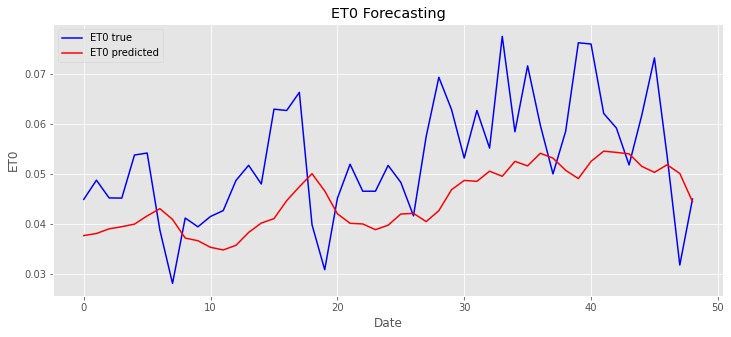

In [77]:
plt.figure(figsize=(12,5))  
plt.plot(y_val, color='blue', label='ET0 true')  
plt.plot(y_pred, color='red', label='ET0 predicted')  
plt.title('ET0 Forecasting')  
plt.xlabel('Date')  
plt.ylabel('ET0')  
plt.legend()
#plt.savefig("eto.png")
plt.show()

In [78]:
X_test = pd.read_csv('X_test.csv', index_col=['date'])
y_test = pd.read_csv('y_test.csv', index_col=['date'])

test_data = pd.concat([X_test, y_test], axis=1)

In [79]:
X_test, y_test = split_sequence(test_data['reference_evapotranspiration'].values, 5)

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [80]:
y_pred_test = model.predict(X_test, verbose=1)

2/2 [==============================] - 0s 9ms/step


In [81]:
y_pred_test = np.array([val for sublist in y_pred_test for val in sublist])

In [82]:
mae_test = mean_absolute_error(y_test, y_pred_test)
mae_test

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
rmse_test

print("MAE: ", mae_test)
print("RMSE: ",rmse_test)

MAE:  tf.Tensor(0.0144845545, shape=(), dtype=float32)
RMSE:  0.016682127


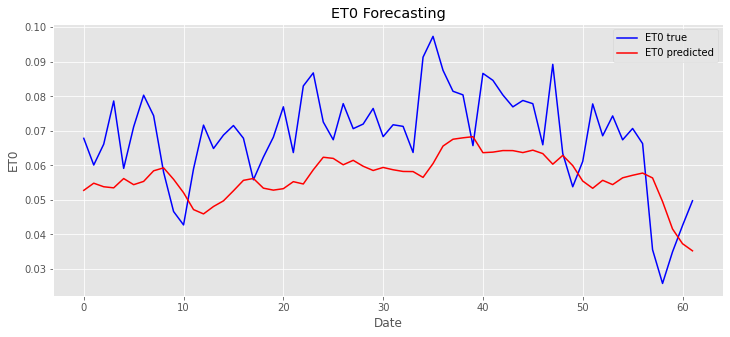

In [83]:
plt.figure(figsize=(12,5))  
plt.plot(y_test, color='blue', label='ET0 true')  
plt.plot(y_pred_test, color='red', label='ET0 predicted')  
plt.title('ET0 Forecasting')  
plt.xlabel('Date')  
plt.ylabel('ET0')  
plt.legend()
#plt.savefig("eto.png")
plt.show()

# Saving bidirectional-LSTM model and applying transfer learning

In [84]:
model.save('bidirectional_lstm_model.h5')

In [85]:
loaded_model=tf.keras.models.load_model('bidirectional_lstm_model.h5')

In [86]:
loaded_model.layers

In [96]:
model1=Sequential()
for layer in loaded_model.layers[:-1]:
 model1.add(layer)
 
# Freeze all the layers of base model
for layer in loaded_model.layers:
 layer.trainable=False
 
# adding new layers
model1.add(Dense(16,input_dim=1))
model1.add(Dropout(0.2))
model1.add(Dense(1))

In [97]:
model1.build(input_shape=(None,5,1))

In [98]:
model1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 64)               8704      
 nal)                                                            
                                                                 
 dense_13 (Dense)            (None, 16)                1040      
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 9,761
Trainable params: 1,057
Non-trainable params: 8,704
_________________________________________________________________


In [99]:
model1.compile(optimizer='adam', 
              loss='mean_absolute_error', 
              metrics=[mean_absolute_error, mean_squared_error])

In [100]:
%%time
model1.fit(X, y, epochs=40, verbose=1)

Epoch 1/40
7/7 [==============================] - 4s 7ms/step - loss: 0.0183 - mean_absolute_error: 0.0183 - mean_squared_error: 5.4956e-04
Epoch 2/40
7/7 [==============================] - 0s 6ms/step - loss: 0.0152 - mean_absolute_error: 0.0152 - mean_squared_error: 3.2007e-04
Epoch 3/40
7/7 [==============================] - 0s 6ms/step - loss: 0.0121 - mean_absolute_error: 0.0121 - mean_squared_error: 2.5251e-04
Epoch 4/40
7/7 [==============================] - 0s 6ms/step - loss: 0.0114 - mean_absolute_error: 0.0114 - mean_squared_error: 2.2056e-04
Epoch 5/40
7/7 [==============================] - 0s 6ms/step - loss: 0.0104 - mean_absolute_error: 0.0104 - mean_squared_error: 1.8562e-04
Epoch 6/40
7/7 [==============================] - 0s 6ms/step - loss: 0.0109 - mean_absolute_error: 0.0109 - mean_squared_error: 1.9740e-04
Epoch 7/40
7/7 [==============================] - 0s 7ms/step - loss: 0.0099 - mean_absolute_error: 0.0099 - mean_squared_error: 1.6378e-04
Epoch 8/40
7/7 [====

In [101]:
y_pred_test_1 = model1.predict(X_test, verbose=1)

2/2 [==============================] - 0s 7ms/step


In [102]:
y_pred_test_1 = np.array([val for sublist in y_pred_test_1 for val in sublist])

In [103]:
mae_test = mean_absolute_error(y_test, y_pred_test_1)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test_1))

print("MAE: ", mae_test)
print("RMSE: ",rmse_test)

MAE:  tf.Tensor(0.010883367, shape=(), dtype=float32)
RMSE:  0.013236719


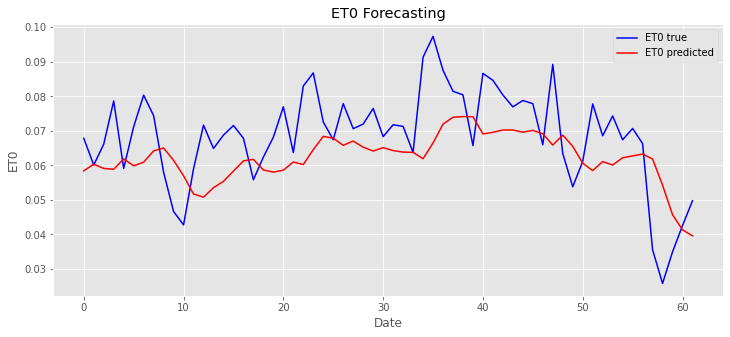

In [104]:
plt.figure(figsize=(12,5))  
plt.plot(y_test, color='blue', label='ET0 true')  
plt.plot(y_pred_test_1, color='red', label='ET0 predicted')  
plt.title('ET0 Forecasting')  
plt.xlabel('Date')  
plt.ylabel('ET0')  
plt.legend()
#plt.savefig("eto.png")
plt.show()